### IMPORTS

In [1]:
import monai
import torch
import itk
import numpy as np
import matplotlib.pyplot as plt
import random
import glob
import os.path
import tempfile

from utils import (
    preview_image,
    preview_3D_vector_field,
    preview_3D_deformation,
    jacobian_determinant,
    plot_against_epoch_numbers,
)

### Without %matplotlib inline:

Your matplotlib plots might not display automatically inside the notebook.

Sometimes, plots may not appear at all unless you explicitly call plt.show().

In [2]:
%matplotlib inline

### For Replicability of MONAI

In [3]:
# Set deterministic training for reproducibility
monai.utils.set_determinism(seed=55)

### Disabling TF32 (TensorFloat-32) precision

Disabling it ensures higher precision, though with a slight performance hit.

In [4]:
# Turn off the TF32 precision. Otherwise, because of the rounding error, the ssim_loss will be a weird value on some Ampere GPUs, like L40, 3090Ti and 3080Ti.
# Track this issue (https://github.com/Project-MONAI/tutorials/issues/1336) for more detail.
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

### Printing out important environment and configuration details related to the MONAI setup.

In [5]:
monai.config.print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.7.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: c:\Users\<username>\OneDrive\Desktop\Feri_Choreko\uwhaa\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.4.3
Nibabel version: 5.3.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 11.2.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.22.1+cu118
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynr

However, when you activate a virtual environment, the activation script can set or modify environment variables temporarily for that session.

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)

root_dir = r"C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root"
os.makedirs(root_dir, exist_ok=True)  # Creates the directory if it doesn't exist

# Create data directory path inside root_dir
# data_dir = os.path.join(root_dir, "IBSR_Img")
print(f"Root directory: {root_dir}")
# print(f"Data directory: {data_dir}")

Root directory: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root


Number of classes

In [7]:
num_segmentation_classes = 4  # background, CSF, white matter, gray matter

Adjusting Path

In [8]:
segmentation_path_expression = "IBSR_Mask/IBSR_*_segTRI_fill_ana.nii"

import glob

image_paths = glob.glob(r"C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_*_ana_strip.nii")
segmentation_paths = glob.glob(r"C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Mask\IBSR_*_segTRI_fill_ana.nii")


print(image_paths)
print(len(image_paths),"\n")

print(segmentation_paths)
print(len(segmentation_paths),"\n")


['C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_01_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_02_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_03_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_04_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_05_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_06_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_07_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_08_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_09_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_10_ana_strip.nii', 'C:\\User

This part of the code is done intentionally to restrict the number of labeled segmentation images to 10, in order to:
Simulate data scarcity,
Speed up development,
Or experiment with semi-supervised methods.


The following code randomly shuffles the list of segmentation file paths and then selects only the first 10 from the shuffled list.
**Why?**
It’s simulating a scenario where only a limited number of segmentation masks are available for training—useful for experimenting with semi-supervised or few-shot learning, or just to reduce dataset size for faster testing.


In [9]:
# pretend that only a few segmentations are available
num_segs_to_select = 10
np.random.shuffle(segmentation_paths)
segmentation_paths = segmentation_paths[:num_segs_to_select]
print(segmentation_paths)
print(len(segmentation_paths),"\n")

['C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_16_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_03_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_10_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_12_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_05_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_11_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_04_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_01_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_07_segTRI_fill_ana.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_C

Resizing

In [10]:
resize = 96

Set device

cuda:0 refers to the first GPU device on your system that supports CUDA (i.e., NVIDIA GPU acceleration).



In [11]:
import torch
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.get_device_name(0))  # Should print your GPU name
device = torch.device("cuda:0")
print(device)

True
NVIDIA GeForce RTX 3070 Laptop GPU
cuda:0


In [12]:
# Function to extract the image ID from the file path
def path_to_id(path):
    return "_".join(os.path.basename(path).split("_")[:2])

seg_ids = list(map(path_to_id, segmentation_paths))
print(seg_ids,"\n")
img_ids = map(path_to_id, image_paths)
print(img_ids,"\n")


['IBSR_16', 'IBSR_03', 'IBSR_10', 'IBSR_12', 'IBSR_05', 'IBSR_11', 'IBSR_04', 'IBSR_01', 'IBSR_07', 'IBSR_02'] 




This code block creates a list called data, where each element is a dictionary representing a data sample. It links each image path with its corresponding segmentation path (if available), based on matching IDs.



In [13]:
data = []
for img_index, img_id in enumerate(img_ids):
    data_item = {"img": image_paths[img_index]} # Create a dictionary with the image file path
    if img_id in seg_ids: # Check if this image has a corresponding segmentation file
        data_item["seg"] = segmentation_paths[seg_ids.index(img_id)] # Add segmentation file path to the dictionary
    data.append(data_item) # Add this dictionary to the data list
print(data)
print(len(data),"\n")

[{'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_01_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_01_segTRI_fill_ana.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_02_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_02_segTRI_fill_ana.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_03_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_03_segTRI_fill_ana.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_04_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_04_segTRI_fill_ana.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_05_ana_strip.nii', 'seg': '

In [14]:
from monai.transforms import LoadImage
import torch

# Initialize the loader
loader = LoadImage(image_only=True)

# Loop over each item in your data list
for idx, item in enumerate(data):
    print(f"\nData index: {idx}")

    # Load and print the shape of the image
    img_tensor = loader(item["img"])
    print(f"Image path: {item['img']}")
    print(f"Image shape (torch tensor): {img_tensor.shape}")

    # Load and print the shape of the segmentation if it exists
    if "seg" in item:
        seg_tensor = loader(item["seg"])
        print(f"Segmentation path: {item['seg']}")
        print(f"Segmentation shape (torch tensor): {seg_tensor.shape}")



Data index: 0
Image path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_01_ana_strip.nii
Image shape (torch tensor): torch.Size([256, 128, 256])
Segmentation path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Mask\IBSR_01_segTRI_fill_ana.nii
Segmentation shape (torch tensor): torch.Size([256, 128, 256, 1])

Data index: 1
Image path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_02_ana_strip.nii
Image shape (torch tensor): torch.Size([256, 128, 256])
Segmentation path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Mask\IBSR_02_segTRI_fill_ana.nii
Segmentation shape (torch tensor): torch.Size([256, 128, 256, 1])

Data index: 2
Image path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_03_ana_strip.nii
Image shape (torch tensor): torch.Size([256, 128, 256])
Segmentation path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Mask\IBSR_03_segTRI_fill_ana.nii
Segmentation 

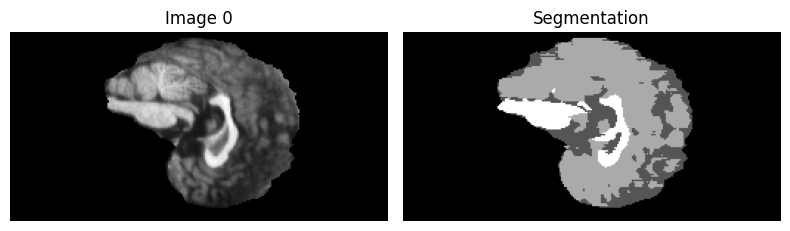

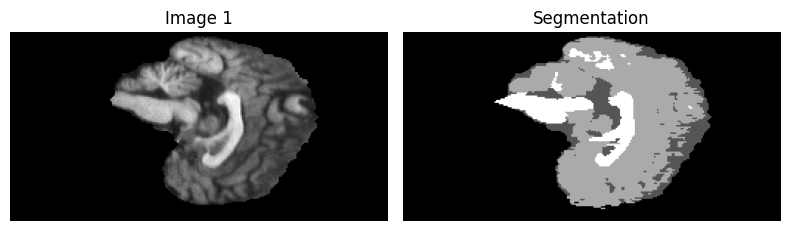

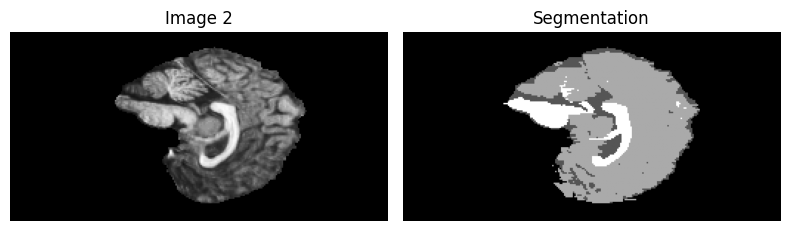

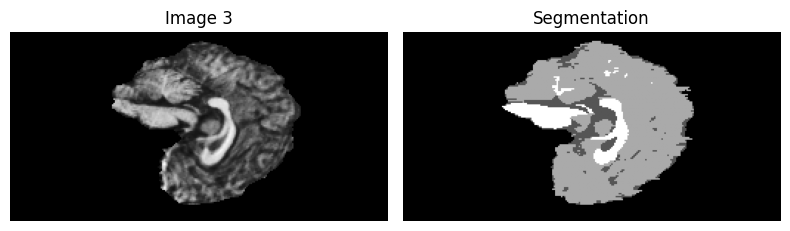

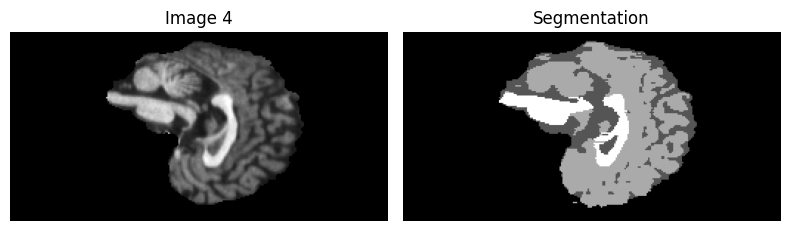

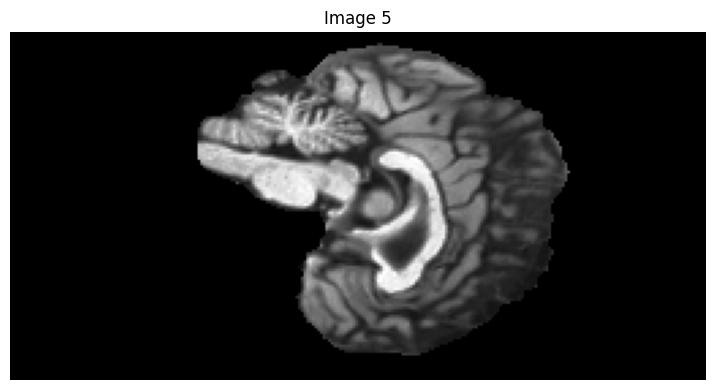

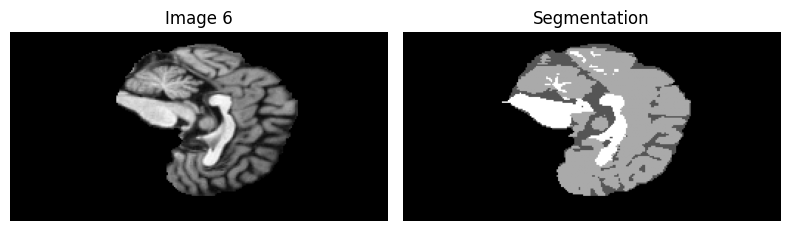

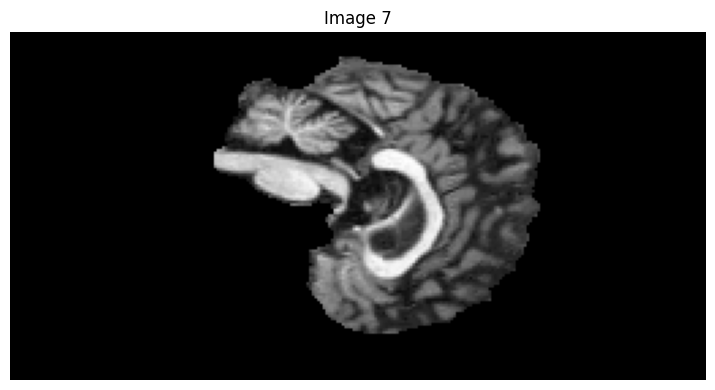

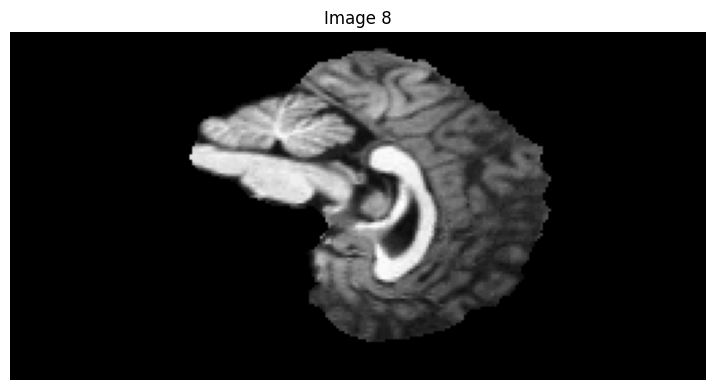

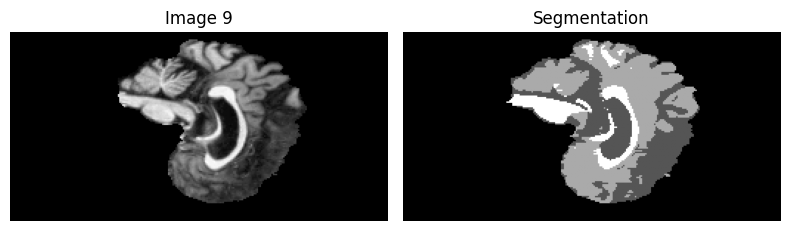

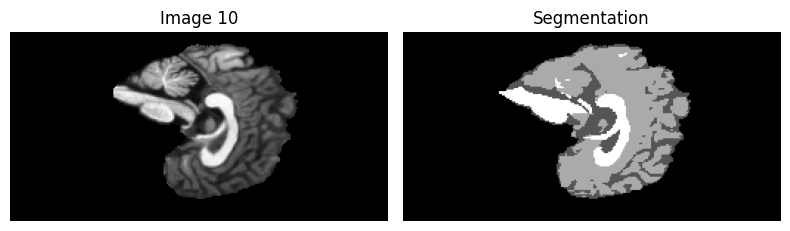

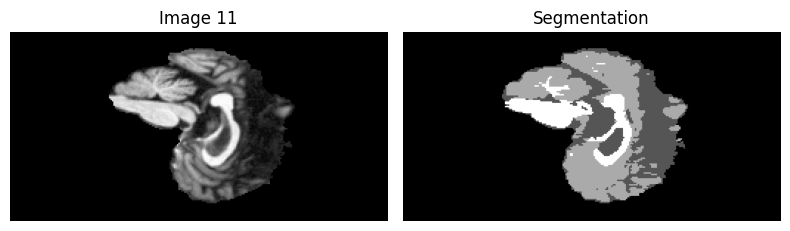

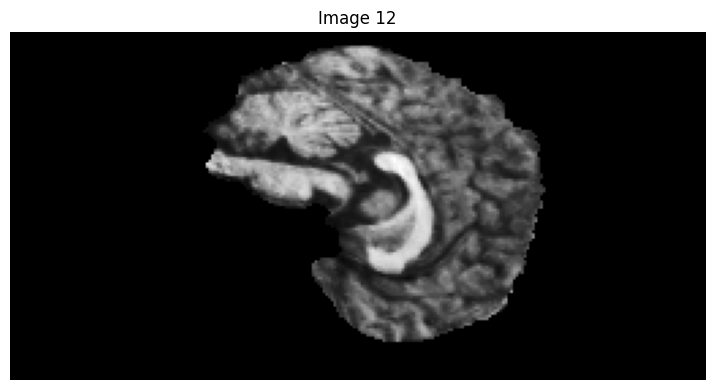

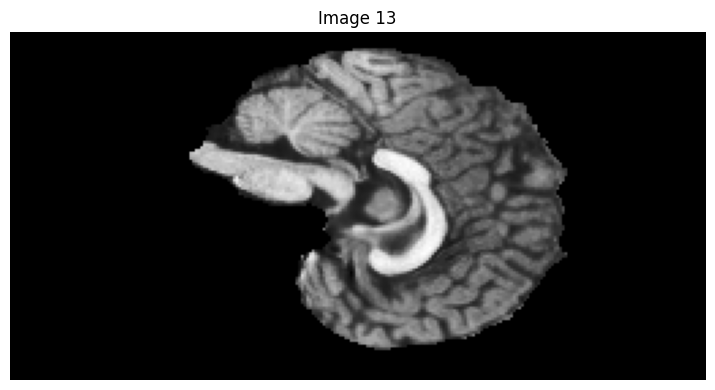

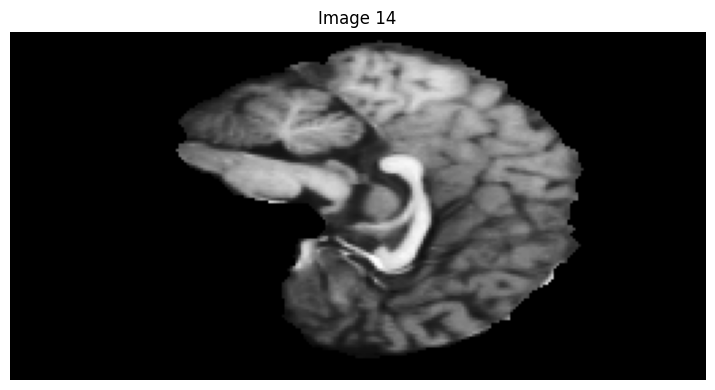

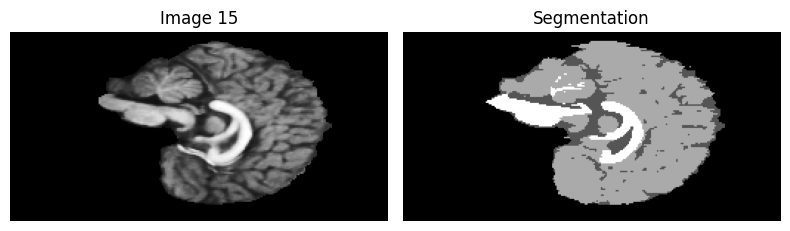

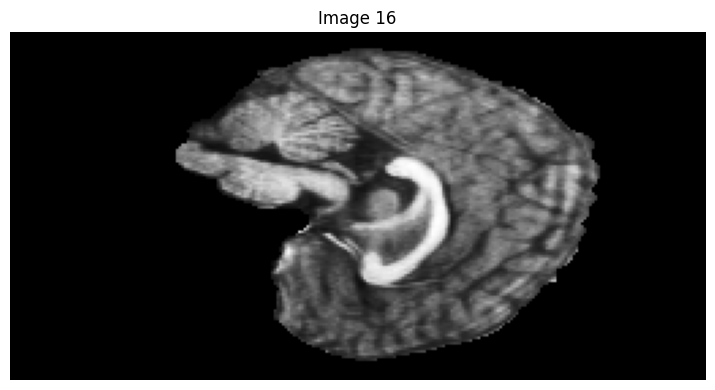

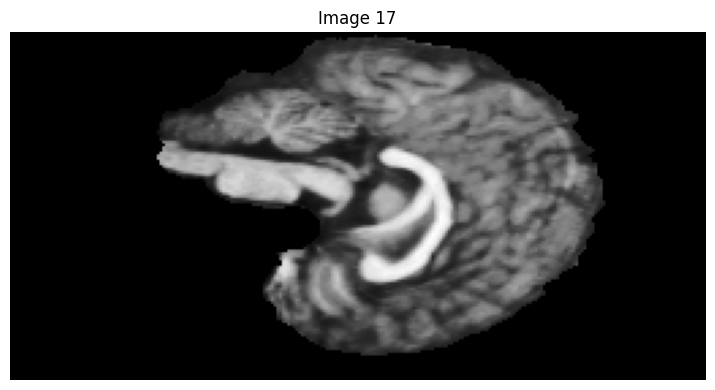

In [15]:
import matplotlib.pyplot as plt
from monai.transforms import LoadImage

# Loader to convert filepath to array
loader = LoadImage(image_only=True)

for i, item in enumerate(data):
    img = loader(item["img"])
    
    has_seg = "seg" in item
    fig, axs = plt.subplots(1, 2 if has_seg else 1, figsize=(8, 4))
    
    # Ensure axs is always a list for uniform access
    if not has_seg:
        axs = [axs]
    
    # Display the image (middle slice)
    axs[0].imshow(img[img.shape[0] // 2], cmap='gray')
    axs[0].set_title(f"Image {i}")
    axs[0].axis('off')

    # If segmentation exists, display it too
    if has_seg:
        seg = loader(item["seg"])
        axs[1].imshow(seg[seg.shape[0] // 2], cmap='gray')
        axs[1].set_title("Segmentation")
        axs[1].axis('off')

    plt.tight_layout()
    plt.show()


In [16]:
from monai.transforms import LoadImaged
import torch

# Set up the loader
loader = LoadImaged(keys=["img", "seg"], ensure_channel_first=True)

# Loop through your data list
for i, item in enumerate(data):
    print(f"\nItem {i}:")

    # Prepare keys (not all have 'seg')
    keys_to_load = ["img"]
    if "seg" in item:
        keys_to_load.append("seg")

    load = LoadImaged(keys=keys_to_load, ensure_channel_first=True)
    loaded_item = load(item)

    print("  img shape:", loaded_item["img"].shape)
    if "seg" in loaded_item:
        print("  seg shape:", loaded_item["seg"].shape)
    else:
        print("  seg: Not available")



Item 0:
  img shape: torch.Size([1, 256, 128, 256])
  seg shape: torch.Size([1, 256, 128, 256])

Item 1:
  img shape: torch.Size([1, 256, 128, 256])
  seg shape: torch.Size([1, 256, 128, 256])

Item 2:
  img shape: torch.Size([1, 256, 128, 256])
  seg shape: torch.Size([1, 256, 128, 256])

Item 3:
  img shape: torch.Size([1, 256, 128, 256])
  seg shape: torch.Size([1, 256, 128, 256])

Item 4:
  img shape: torch.Size([1, 256, 128, 256])
  seg shape: torch.Size([1, 256, 128, 256])

Item 5:
  img shape: torch.Size([1, 256, 128, 256])
  seg: Not available

Item 6:
  img shape: torch.Size([1, 256, 128, 256])
  seg shape: torch.Size([1, 256, 128, 256])

Item 7:
  img shape: torch.Size([1, 256, 128, 256])
  seg: Not available

Item 8:
  img shape: torch.Size([1, 256, 128, 256])
  seg: Not available

Item 9:
  img shape: torch.Size([1, 256, 128, 256])
  seg shape: torch.Size([1, 256, 128, 256])

Item 10:
  img shape: torch.Size([1, 256, 128, 256])
  seg shape: torch.Size([1, 256, 128, 256])



Displaying a random image

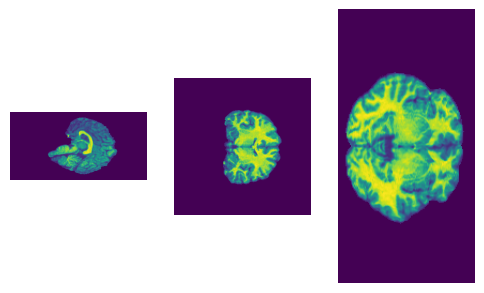

In [17]:
data_item = random.choice(data)
preview_image(monai.transforms.LoadImage(image_only=True)(data_item['img']), figsize=(6,6), normalize_by="slice")

This code splits the dataset data into two groups:
Items that have segmentation labels, and
Items that don't — then splits the first group for training and validation.

Useful for:
Semi-supervised learning
Unlabeled inference/evaluation



In [18]:
from monai.transforms import LoadImage

# Set up the loader
loader = LoadImage(image_only=True)

# Print the shape of all loaded segmentation masks
def print_all_seg_shapes(data):
    for i, data_item in enumerate(data):
        if "seg" in data_item:
            seg_tensor = loader(data_item["seg"])  # load from path
            print(f"Item {i}: seg shape = {seg_tensor.shape}")
        else:
            print(f"Item {i}: seg key not found")

# Run it
print_all_seg_shapes(data)


Item 0: seg shape = torch.Size([256, 128, 256, 1])
Item 1: seg shape = torch.Size([256, 128, 256, 1])
Item 2: seg shape = torch.Size([256, 128, 256, 1])
Item 3: seg shape = torch.Size([256, 128, 256, 1])
Item 4: seg shape = torch.Size([256, 128, 256, 1])
Item 5: seg key not found
Item 6: seg shape = torch.Size([256, 128, 256, 1])
Item 7: seg key not found
Item 8: seg key not found
Item 9: seg shape = torch.Size([256, 128, 256, 1])
Item 10: seg shape = torch.Size([256, 128, 256, 1])
Item 11: seg shape = torch.Size([256, 128, 256, 1])
Item 12: seg key not found
Item 13: seg key not found
Item 14: seg key not found
Item 15: seg shape = torch.Size([256, 128, 256, 1])
Item 16: seg key not found
Item 17: seg key not found


In [19]:
# Filters data to keep only entries that contain a segmentation path.
data_seg_available = list(filter(lambda d: "seg" in d.keys(), data))

# Filters data to keep entries that only have an image (no "seg" key).
data_seg_unavailable = list(filter(lambda d: "seg" not in d.keys(), data))

# Splits data_seg_available into:
# 80% for training
# 20% for validation
data_seg_available_train, data_seg_available_valid = monai.data.utils.partition_dataset(
    data_seg_available, ratios=(8, 2)
)
# Validation of the segmentation network only makes sense if you have enough segmentation labels.
# E.g. definitely skip validation here if there's just one segmentation label.

print(f"Number of data items with segmentation labels: {len(data_seg_available)}")
print(f"Number of data items with segmentation labels for training: {len(data_seg_available_train)}")
print(f"Number of data items with segmentation labels for validation: {len(data_seg_available_valid)}")
print(f"Number of data items without segmentation labels: {len(data_seg_unavailable)}")

print(data_seg_available_train)
print(data_seg_available_valid)
print(data_seg_unavailable)

Number of data items with segmentation labels: 10
Number of data items with segmentation labels for training: 8
Number of data items with segmentation labels for validation: 2
Number of data items without segmentation labels: 8
[{'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_01_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_01_segTRI_fill_ana.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_02_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_02_segTRI_fill_ana.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_03_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_03_segTRI_fill_ana.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_04_ana_strip.nii', '

In [20]:
import monai
import torch

# Path to your .nii file
nii_path = r"C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_01_ana_strip.nii"

# Load the image as a PyTorch tensor using MONAI's LoadImage transform
loader = monai.transforms.LoadImage(image_only=True)
img = loader(nii_path)  # returns a numpy array

# Convert to PyTorch tensor
img_tensor = torch.tensor(img)

# Print the shape
print(f"Shape of the loaded image tensor: {img_tensor.shape}")


Shape of the loaded image tensor: torch.Size([256, 128, 256])


To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [40]:
from monai.transforms import LoadImage

# Set up the loader
loader = LoadImage(image_only=True)

# Print the shape of all loaded segmentation masks
def print_all_seg_shapes(data):
    for i, data_item in enumerate(data):
        if "seg" in data_item:
            seg_tensor = loader(data_item["seg"])  # load from path
            print(f"Item {i}: seg shape = {seg_tensor.shape}")
        else:
            print(f"Item {i}: seg key not found")

# Run it
print_all_seg_shapes(data_seg_available)


Item 0: seg shape = torch.Size([256, 128, 256, 1])
Item 1: seg shape = torch.Size([256, 128, 256, 1])
Item 2: seg shape = torch.Size([256, 128, 256, 1])
Item 3: seg shape = torch.Size([256, 128, 256, 1])
Item 4: seg shape = torch.Size([256, 128, 256, 1])
Item 5: seg shape = torch.Size([256, 128, 256, 1])
Item 6: seg shape = torch.Size([256, 128, 256, 1])
Item 7: seg shape = torch.Size([256, 128, 256, 1])
Item 8: seg shape = torch.Size([256, 128, 256, 1])
Item 9: seg shape = torch.Size([256, 128, 256, 1])


Preprocessing

In [66]:
resize = 96

def squeeze_last_dim(x):
    # If the tensor has 4 dims and last dim == 1, squeeze it
    if x.ndim == 4 and x.shape[-1] == 1:
        return x.squeeze(-1)
    return x

def unsqueeze_last_dim(x):
    # If the tensor has 3 dims, unsqueeze the last dim
    if x.ndim == 3:
        return x.unsqueeze(-1)
    return x

def print_shape(x):
    print(f"Tensor shape: {x.shape}")
    return x

transform_seg_available = monai.transforms.Compose(
    transforms = [
        monai.transforms.LoadImageD(keys=["img", "seg"], image_only=True),
        # monai.transforms.LambdaD(keys=["img", "seg"], func=print_shape),
        # monai.transforms.LambdaD(keys=["img", "seg"], func=squeeze_last_dim),  # <-- added here
        monai.transforms.EnsureChannelFirstD(keys=["img", "seg"]),
        # monai.transforms.LambdaD(keys=["img", "seg"], func=print_shape),
        monai.transforms.EnsureTypeD(keys=["img", "seg"]),
        # monai.transforms.LambdaD(keys=["img", "seg"], func=print_shape),
        monai.transforms.TransposeD(keys=["img", "seg"], indices=(0,1,2,3)),
        # monai.transforms.LambdaD(keys=["img", "seg"], func=print_shape),
        # monai.transforms.LambdaD(keys=["img", "seg"], func=unsqueeze_last_dim),  # <-- added here
        (
            monai.transforms.ResizeD(
                keys=["img", "seg"],
                spatial_size=(96, 96, 96),
                mode=["trilinear", "nearest"],
                align_corners=[False, None],
            )
            if resize is not None
            else monai.transforms.Identity()
        ),
    ]
)

# Supress the many warnings related to deprecation of the Analyze file format
# (without this, we would see warnings when the LoadImage transform calls itk to load Analyze files)
itk.ProcessObject.SetGlobalWarningDisplay(False)

# Uncomment the following lines to preview a random image with the transform above applied
data_item = transform_seg_available(random.choice(data_seg_available))

# preview_image(data_item['img'][0])
# preview_image(data_item['seg'][0])

# print(type(data_item['img'][0]))
# print(data_item['img'][0].shape)
# print(data_item['img'][0].min(), data_item['seg'][0].max())

# print(type(data_item['seg'][0]))
# print(data_item['seg'][0].shape)
# print(data_item['seg'][0].min(), data_item['seg'][0].max())

In [67]:
from monai.transforms import LoadImage

# Set up the loader
loader = LoadImage(image_only=True)

# Print the shape of all loaded segmentation masks
def print_all_seg_shapes(data):
    for i, data_item in enumerate(data):
        if "seg" in data_item:
            seg_tensor = loader(data_item["seg"])  # load from path
            print(f"Item {i}: seg shape = {seg_tensor.shape}")
        else:
            print(f"Item {i}: seg key not found")

# Run it
print_all_seg_shapes(data_seg_available_train)
print("-----------------------------------------------")
print_all_seg_shapes(data_seg_available_valid)


Item 0: seg shape = torch.Size([256, 128, 256, 1])
Item 1: seg shape = torch.Size([256, 128, 256, 1])
Item 2: seg shape = torch.Size([256, 128, 256, 1])
Item 3: seg shape = torch.Size([256, 128, 256, 1])
Item 4: seg shape = torch.Size([256, 128, 256, 1])
Item 5: seg shape = torch.Size([256, 128, 256, 1])
Item 6: seg shape = torch.Size([256, 128, 256, 1])
Item 7: seg shape = torch.Size([256, 128, 256, 1])
-----------------------------------------------
Item 0: seg shape = torch.Size([256, 128, 256, 1])
Item 1: seg shape = torch.Size([256, 128, 256, 1])


In [68]:
dataset_seg_available_train = monai.data.CacheDataset(
    data=data_seg_available_train, transform=transform_seg_available, cache_num=4 # 16
)

dataset_seg_available_valid = monai.data.CacheDataset(
    data=data_seg_available_valid, transform=transform_seg_available, cache_num=4 # 16
)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  4.84it/s]


In [69]:
def print_all_seg_shapes(data):
    for i, data_item in enumerate(data):
        if "seg" in data_item:
            seg_tensor = data_item["seg"]
            print(f"Item {i}: seg shape = {seg_tensor.shape}")
        else:
            print(f"Item {i}: seg key not found")

print_all_seg_shapes(dataset_seg_available_train)

Item 0: seg shape = torch.Size([1, 96, 96, 96])
Item 1: seg shape = torch.Size([1, 96, 96, 96])
Item 2: seg shape = torch.Size([1, 96, 96, 96])
Item 3: seg shape = torch.Size([1, 96, 96, 96])
Item 4: seg shape = torch.Size([1, 96, 96, 96])
Item 5: seg shape = torch.Size([1, 96, 96, 96])
Item 6: seg shape = torch.Size([1, 96, 96, 96])
Item 7: seg shape = torch.Size([1, 96, 96, 96])


Dataset for both seg and reg combined

In [70]:
# During the joint/alternating training process, we will use reuse data_seg_available_valid
# for validating the segmentation network.
# So we should not let the registration or segmentation networks see these images in training.
data_without_seg_valid = data_seg_unavailable + data_seg_available_train  # Note the order

In [71]:
from monai.transforms import LoadImage

# Set up the loader
loader = LoadImage(image_only=True)

# Print the shape of all loaded segmentation masks
def print_all_seg_shapes(data):
    for i, data_item in enumerate(data):
        if "seg" in data_item:
            seg_tensor = loader(data_item["seg"])  # load from path
            print(f"Item {i}: seg shape = {seg_tensor.shape}")
        else:
            print(f"Item {i}: seg key not found")

# Run it
print_all_seg_shapes(data_without_seg_valid)


Item 0: seg key not found
Item 1: seg key not found
Item 2: seg key not found
Item 3: seg key not found
Item 4: seg key not found
Item 5: seg key not found
Item 6: seg key not found
Item 7: seg key not found
Item 8: seg shape = torch.Size([256, 128, 256, 1])
Item 9: seg shape = torch.Size([256, 128, 256, 1])
Item 10: seg shape = torch.Size([256, 128, 256, 1])
Item 11: seg shape = torch.Size([256, 128, 256, 1])
Item 12: seg shape = torch.Size([256, 128, 256, 1])
Item 13: seg shape = torch.Size([256, 128, 256, 1])
Item 14: seg shape = torch.Size([256, 128, 256, 1])
Item 15: seg shape = torch.Size([256, 128, 256, 1])


Checking data_without_seg_valid

In [72]:
from monai.transforms import LoadImage
from monai.data import MetaTensor

# Initialize MONAI loader
loader = LoadImage(image_only=True)  # set image_only=True to get just the image array

def print_monai_nii_shapes(data_list):
    for i, item in enumerate(data_list):
        img_path = item.get('image') or item.get('img')
        seg_path = item.get('seg') or item.get('segmentation')

        # Load image
        img = loader(img_path)
        if isinstance(img, MetaTensor):
            img_shape = img.shape
        else:
            img_shape = img.shape if hasattr(img, 'shape') else None

        print(f"Image {i+1}: {img_path}, Shape: {img_shape}")

        # Load segmentation if available
        if seg_path:
            seg = loader(seg_path)
            seg_shape = seg.shape if hasattr(seg, 'shape') else None
            print(f"Segmentation {i+1}: {seg_path}, Shape: {seg_shape}")
        print()  # newline for better readability

# Call the function
print_monai_nii_shapes(data_without_seg_valid)


Image 1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_06_ana_strip.nii, Shape: torch.Size([256, 128, 256])

Image 2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_08_ana_strip.nii, Shape: torch.Size([256, 128, 256])

Image 3: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_09_ana_strip.nii, Shape: torch.Size([256, 128, 256])

Image 4: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_13_ana_strip.nii, Shape: torch.Size([256, 128, 256])

Image 5: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_14_ana_strip.nii, Shape: torch.Size([256, 128, 256])

Image 6: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_15_ana_strip.nii, Shape: torch.Size([256, 128, 256])

Image 7: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_17_ana_strip.nii, Shape: torch.Size([256, 128, 256])

Image 8: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_r

In [73]:
# For validation of the registration network, we prefer not to use the precious data_seg_available_train,
# if that's possible. The following split tries to use data_seg_unavailable for the
# the validation set, to the extent possible.
data_valid, data_train = monai.data.utils.partition_dataset(
    data_without_seg_valid, ratios=(2, 8), shuffle=False  # Note the order  # Note the order
)

In [74]:
print_monai_nii_shapes(data_valid)
print("---\n")
print_monai_nii_shapes(data_train)

Image 1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_06_ana_strip.nii, Shape: torch.Size([256, 128, 256])

Image 2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_08_ana_strip.nii, Shape: torch.Size([256, 128, 256])

Image 3: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_09_ana_strip.nii, Shape: torch.Size([256, 128, 256])

---

Image 1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_13_ana_strip.nii, Shape: torch.Size([256, 128, 256])

Image 2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_14_ana_strip.nii, Shape: torch.Size([256, 128, 256])

Image 3: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_15_ana_strip.nii, Shape: torch.Size([256, 128, 256])

Image 4: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_17_ana_strip.nii, Shape: torch.Size([256, 128, 256])

Image 5: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OA

The following function creates all possible pairs of images from the input list (except pairing with self).

Segmentations are included in pairs if available.

This is useful for tasks like image registration, where pairs of images (and masks) are needed.

In [75]:
def take_data_pairs(data, symmetric=True):
    """Given a list of dicts that have keys for an image and maybe a segmentation,
    return a list of dicts corresponding to *pairs* of images and maybe segmentations.
    Pairs consisting of a repeated image are not included.
    If symmetric is set to True, then for each pair that is included, its reverse is also included"""
    data_pairs = []
    for i in range(len(data)):
        j_limit = len(data) if symmetric else i
        for j in range(j_limit):
            if j == i:
                continue
            d1 = data[i]
            d2 = data[j]
            pair = {"img1": d1["img"], "img2": d2["img"]}
            if "seg" in d1.keys():
                pair["seg1"] = d1["seg"]
            if "seg" in d2.keys():
                pair["seg2"] = d2["seg"]
            data_pairs.append(pair)
    return data_pairs


data_pairs_valid = take_data_pairs(data_valid)
data_pairs_train = take_data_pairs(data_train)

In [76]:
def print_data_pairs(data_pairs, max_print=5):
    print(f"Total pairs: {len(data_pairs)}\n")
    for i, pair in enumerate(data_pairs):
        if i >= max_print:
            print(f"... and {len(data_pairs) - max_print} more pairs.")
            break
        print(f"Pair {i + 1}:")
        print(f"  img1: {pair.get('img1')}")
        print(f"  img2: {pair.get('img2')}")
        if 'seg1' in pair:
            print(f"  seg1: {pair['seg1']}")
        if 'seg2' in pair:
            print(f"  seg2: {pair['seg2']}")
        print()

print("Validation Data Pairs:")
print_data_pairs(data_pairs_valid)

print("\nTraining Data Pairs:")
print_data_pairs(data_pairs_train)


Validation Data Pairs:
Total pairs: 6

Pair 1:
  img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_06_ana_strip.nii
  img2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_08_ana_strip.nii

Pair 2:
  img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_06_ana_strip.nii
  img2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_09_ana_strip.nii

Pair 3:
  img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_08_ana_strip.nii
  img2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_06_ana_strip.nii

Pair 4:
  img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_08_ana_strip.nii
  img2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_09_ana_strip.nii

Pair 5:
  img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_09_ana_strip.nii
  img2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko

It sorts the list of image pairs into four groups based on the presence or absence of segmentation data for each image in the pair.

"11": Both images have segmentations ("seg1" and "seg2" are present).

"10": Only the first image has a segmentation ("seg1" present, "seg2" absent).

"01": Only the second image has a segmentation ("seg2" present, "seg1" absent).

"00": Neither image has segmentation (no "seg1" or "seg2").

In [77]:
def subdivide_list_of_data_pairs(data_pairs_list):
    out_dict = {"00": [], "01": [], "10": [], "11": []}
    for d in data_pairs_list:
        if "seg1" in d.keys() and "seg2" in d.keys():
            out_dict["11"].append(d)
        elif "seg1" in d.keys():
            out_dict["10"].append(d)
        elif "seg2" in d.keys():
            out_dict["01"].append(d)
        else:
            out_dict["00"].append(d)
    return out_dict


data_pairs_valid_subdivided = subdivide_list_of_data_pairs(data_pairs_valid)
data_pairs_train_subdivided = subdivide_list_of_data_pairs(data_pairs_train)

print(data_pairs_train_subdivided, "\n")
print(data_pairs_valid_subdivided, "\n")

{'00': [{'img1': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_13_ana_strip.nii', 'img2': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_14_ana_strip.nii'}, {'img1': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_13_ana_strip.nii', 'img2': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_15_ana_strip.nii'}, {'img1': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_13_ana_strip.nii', 'img2': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_17_ana_strip.nii'}, {'img1': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_13_ana_strip.nii', 'img2': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_18_ana_strip.nii'}, {'img1': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_14_ana_strip.nii', 'img2': 'C:\\Users\\

In [78]:
def print_subdivided_data_pairs(data_dict, title="Data Pairs Subdivided"):
    print(title)
    for key in sorted(data_dict.keys()):
        print(f"\nCategory '{key}' - Total: {len(data_dict[key])}")
        for i, pair in enumerate(data_dict[key], 1):
            print(f"  Pair {i}:")
            for k, v in pair.items():
                print(f"    {k}: {v}")
        if len(data_dict[key]) == 0:
            print("    (No pairs)")

print_subdivided_data_pairs(data_pairs_train_subdivided, "Training Data Pairs Subdivided")
print("\n" + "="*40 + "\n")
print_subdivided_data_pairs(data_pairs_valid_subdivided, "Validation Data Pairs Subdivided")


Training Data Pairs Subdivided

Category '00' - Total: 20
  Pair 1:
    img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_13_ana_strip.nii
    img2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_14_ana_strip.nii
  Pair 2:
    img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_13_ana_strip.nii
    img2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_15_ana_strip.nii
  Pair 3:
    img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_13_ana_strip.nii
    img2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_17_ana_strip.nii
  Pair 4:
    img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_13_ana_strip.nii
    img2: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_18_ana_strip.nii
  Pair 5:
    img1: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_14_ana_strip.nii
    img2: 

This code loads the medical images and segmentations from your data pairs (train & validation), prints the shape of each loaded .nii file (so you can verify they are loading correctly and have expected dimensions), and also prints their filenames for reference. It helps you inspect and verify your dataset contents before training or analysis.

In [79]:
from monai.transforms import LoadImage
import os

# Initialize the MONAI image loader
loader = LoadImage(image_only=True)

def print_nii_shapes(data_pairs_dict, name=""):
    print(f"\n--- Shapes from {name} ---")
    for category, data_list in data_pairs_dict.items():
        print(f"\nCategory: {category} ({len(data_list)} pairs)")
        for i, item in enumerate(data_list[:5]):  # Limit to 5 items for brevity
            print(f"\nPair {i+1}:")
            for key in ["img1", "img2", "seg1", "seg2"]:
                if key in item:
                    try:
                        img = loader(item[key])
                        print(f"{key}: {img.shape} - {os.path.basename(item[key])}")
                    except Exception as e:
                        print(f"{key}: Error loading {item[key]} -> {e}")

# Print shapes from training and validation
print_nii_shapes(data_pairs_train_subdivided, name="Training")
print_nii_shapes(data_pairs_valid_subdivided, name="Validation")



--- Shapes from Training ---

Category: 00 (20 pairs)

Pair 1:
img1: torch.Size([256, 128, 256]) - IBSR_13_ana_strip.nii
img2: torch.Size([256, 128, 256]) - IBSR_14_ana_strip.nii

Pair 2:
img1: torch.Size([256, 128, 256]) - IBSR_13_ana_strip.nii
img2: torch.Size([256, 128, 256]) - IBSR_15_ana_strip.nii

Pair 3:
img1: torch.Size([256, 128, 256]) - IBSR_13_ana_strip.nii
img2: torch.Size([256, 128, 256]) - IBSR_17_ana_strip.nii

Pair 4:
img1: torch.Size([256, 128, 256]) - IBSR_13_ana_strip.nii
img2: torch.Size([256, 128, 256]) - IBSR_18_ana_strip.nii

Pair 5:
img1: torch.Size([256, 128, 256]) - IBSR_14_ana_strip.nii
img2: torch.Size([256, 128, 256]) - IBSR_13_ana_strip.nii

Category: 01 (40 pairs)

Pair 1:
img1: torch.Size([256, 128, 256]) - IBSR_13_ana_strip.nii
img2: torch.Size([256, 128, 256]) - IBSR_01_ana_strip.nii
seg2: torch.Size([256, 128, 256, 1]) - IBSR_01_segTRI_fill_ana.nii

Pair 2:
img1: torch.Size([256, 128, 256]) - IBSR_13_ana_strip.nii
img2: torch.Size([256, 128, 256]) - 

It tells you how many pairs you can use for joint training (reg + seg) versus how many are only for registration training.

And it tells you how many pairs you have for validation of registration.

In [80]:
# print some useful counts to be aware of

num_train_reg_net = len(data_pairs_train)
num_valid_reg_net = len(data_pairs_valid)
num_train_both = (
    len(data_pairs_train_subdivided["01"])
    + len(data_pairs_train_subdivided["10"])
    + len(data_pairs_train_subdivided["11"])
)


print(
    f"""We have {num_train_both} pairs to train reg_net and seg_net together,
  and an additional {num_train_reg_net - num_train_both} to train reg_net alone."""
)
print(f"We have {num_valid_reg_net} pairs for reg_net validation.")

We have 136 pairs to train reg_net and seg_net together,
  and an additional 20 to train reg_net alone.
We have 6 pairs for reg_net validation.


In [81]:
from monai.transforms import LoadImage

# Set up the loader
loader = LoadImage(image_only=True)

# Print the shape of all loaded segmentation masks
def print_all_seg_shapes(data):
    for i, data_item in enumerate(data):
        if "seg" in data_item:
            seg_tensor = loader(data_item["seg"])  # load from path
            print(f"Item {i}: seg shape = {seg_tensor.shape}")
        else:
            print(f"Item {i}: seg key not found")

# Run it
print_all_seg_shapes(data_pairs_train)


Item 0: seg key not found
Item 1: seg key not found
Item 2: seg key not found
Item 3: seg key not found
Item 4: seg key not found
Item 5: seg key not found
Item 6: seg key not found
Item 7: seg key not found
Item 8: seg key not found
Item 9: seg key not found
Item 10: seg key not found
Item 11: seg key not found
Item 12: seg key not found
Item 13: seg key not found
Item 14: seg key not found
Item 15: seg key not found
Item 16: seg key not found
Item 17: seg key not found
Item 18: seg key not found
Item 19: seg key not found
Item 20: seg key not found
Item 21: seg key not found
Item 22: seg key not found
Item 23: seg key not found
Item 24: seg key not found
Item 25: seg key not found
Item 26: seg key not found
Item 27: seg key not found
Item 28: seg key not found
Item 29: seg key not found
Item 30: seg key not found
Item 31: seg key not found
Item 32: seg key not found
Item 33: seg key not found
Item 34: seg key not found
Item 35: seg key not found
Item 36: seg key not found
Item 37: se

In [82]:
def print_shape(x):
    print(f"Shape before transpose: {x.shape}")
    return x

def print_shapee(x):
    print(f"Shape after transpose: {x.shape}")
    return x

def squeeze_if_needed(x):
    # Squeeze last dim if it's singleton channel dim
    if x.ndim == 4 and x.shape[-1] == 1:
        return x.squeeze(-1)
    return x

transform_pair = monai.transforms.Compose(
    transforms=[
        monai.transforms.LoadImageD(keys=["img1", "seg1", "img2", "seg2"], image_only=True, allow_missing_keys=True),
        monai.transforms.LambdaD(keys=["img1", "seg1", "img2", "seg2"], func=print_shape, allow_missing_keys=True),
        monai.transforms.LambdaD(keys=["img1", "seg1", "img2", "seg2"], func=squeeze_if_needed, allow_missing_keys=True),
        monai.transforms.TransposeD(keys=["img1", "seg1", "img2", "seg2"], indices=(2, 1, 0), allow_missing_keys=True),
        monai.transforms.EnsureChannelFirstD(keys=["img1", "seg1", "img2", "seg2"], allow_missing_keys=True),
        monai.transforms.ConcatItemsD(keys=["img1", "img2"], name="img12", dim=0),
                monai.transforms.LambdaD(keys=["img1", "seg1", "img2", "seg2"], func=print_shapee, allow_missing_keys=True),
        monai.transforms.DeleteItemsD(keys=["img1", "img2"]),
        (
            monai.transforms.ResizeD(
                keys=["img12", "seg1", "seg2"],
                spatial_size=(resize, resize, resize),
                mode=["trilinear", "nearest", "nearest"],
                allow_missing_keys=True,
                align_corners=[False, None, None],
            )
            if resize is not None
            else monai.transforms.Identity()
        ),
    ]
)

In [83]:
# The following are dictionaries that map segmentation availability labels 00,10,01,11 to MONAI datasets

dataset_pairs_train_subdivided = {
    seg_availability: monai.data.CacheDataset(data=data_list, transform=transform_pair, cache_num=4) # 32
    for seg_availability, data_list in data_pairs_train_subdivided.items()
}


dataset_pairs_valid_subdivided = {
    seg_availability: monai.data.CacheDataset(data=data_list, transform=transform_pair, cache_num=4) # 32
    for seg_availability, data_list in data_pairs_valid_subdivided.items()
}

Loading dataset:  25%|██▌       | 1/4 [00:00<00:00,  3.46it/s]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])


Loading dataset:  50%|█████     | 2/4 [00:00<00:00,  3.22it/s]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])


Loading dataset:  75%|███████▌  | 3/4 [00:00<00:00,  3.00it/s]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])


Loading dataset: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]


Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])


Loading dataset:   0%|          | 0/4 [00:00<?, ?it/s]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])


Loading dataset:  25%|██▌       | 1/4 [00:00<00:01,  1.74it/s]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])


Loading dataset:  50%|█████     | 2/4 [00:01<00:01,  1.79it/s]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])


Loading dataset:  75%|███████▌  | 3/4 [00:01<00:00,  1.83it/s]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])


Loading dataset:   0%|          | 0/4 [00:00<?, ?it/s]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape before transpose: torch.Size([256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])
Shape after transpose: torch.Size([1, 256, 128, 256])


Loading dataset:  25%|██▌       | 1/4 [00:00<00:01,  1.53it/s]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape before transpose: torch.Size([256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])
Shape after transpose: torch.Size([1, 256, 128, 256])


Loading dataset:  50%|█████     | 2/4 [00:01<00:01,  1.55it/s]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape before transpose: torch.Size([256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])
Shape after transpose: torch.Size([1, 256, 128, 256])


Loading dataset:  75%|███████▌  | 3/4 [00:02<00:00,  1.39it/s]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape before transpose: torch.Size([256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])
Shape after transpose: torch.Size([1, 256, 128, 256])


Loading dataset:   0%|          | 0/4 [00:00<?, ?it/s]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])


Loading dataset:  25%|██▌       | 1/4 [00:01<00:03,  1.11s/it]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])


Loading dataset:  50%|█████     | 2/4 [00:02<00:02,  1.14s/it]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])


Loading dataset:  75%|███████▌  | 3/4 [00:03<00:01,  1.28s/it]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])


Loading dataset:  25%|██▌       | 1/4 [00:00<00:01,  1.55it/s]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])


Loading dataset:  50%|█████     | 2/4 [00:01<00:01,  1.86it/s]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])


Loading dataset:  75%|███████▌  | 3/4 [00:01<00:00,  2.27it/s]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])


Loading dataset: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([1, 256, 128, 256])


In [84]:
from monai.transforms import LoadImage

# Set up the loader
loader = LoadImage(image_only=True)

# Print the shape of all loaded segmentation masks
def print_all_seg_shapes(data):
    for i, data_item in enumerate(data):
        if "seg" in data_item:
            seg_tensor = loader(data_item["seg"])  # load from path
            print(f"Item {i}: seg shape = {seg_tensor.shape}")
        else:
            print(f"Item {i}: seg key not found")

# Run it
print_all_seg_shapes(dataset_pairs_train_subdivided)


Item 0: seg key not found
Item 1: seg key not found
Item 2: seg key not found
Item 3: seg key not found


Creating a seg network
Unet

In [85]:
dataa_item = random.choice(dataset_seg_available_train)
print(f"Shape of ground truth label: {dataa_item['seg'].unsqueeze(0).shape}")

Shape of ground truth label: torch.Size([1, 1, 96, 96, 96])


In [86]:
seg_net = monai.networks.nets.UNet(
    3,  # spatial dims
    1,  # input channels
    num_segmentation_classes,  # output channels
    (8, 16, 16, 32, 32, 64, 64),  # channel sequence
    (1, 2, 1, 2, 1, 2),  # convolutional strides
    dropout=0.2,
    norm="batch",
)

Forward Pass

In [87]:
# Try out a forward pass

data_item = random.choice(dataset_seg_available_train)
seg_net_example_output = seg_net(data_item["img"].unsqueeze(0))
print(f"Segmentation classes: {torch.unique(data_item['seg']).as_tensor()}")
print(f"Shape of ground truth label: {data_item['seg'].unsqueeze(0).shape}")
print(f"Shape of seg_net output: {seg_net_example_output.shape}")

Segmentation classes: tensor([0., 1., 2., 3.])
Shape of ground truth label: torch.Size([1, 1, 96, 96, 96])
Shape of seg_net output: torch.Size([1, 4, 96, 96, 96])


Dice Loss

In [88]:
dice_loss = monai.losses.DiceLoss(
    include_background=True,
    to_onehot_y=True,  # Our seg labels are single channel images indicating class index, rather than one-hot
    softmax=True,  # Note that our segmentation network is missing the softmax at the end
    reduction="mean",
)

# A version of the dice loss with to_onehot_y=False and softmax=False;
# This will be handy for anatomy loss, for which we often compare two outputs of seg_net
dice_loss2 = monai.losses.DiceLoss(include_background=True, to_onehot_y=False, softmax=False, reduction="mean")

Creating a Reg Network
Unet

In [89]:
# Similar architecture to the one used in the paper
reg_net = monai.networks.nets.UNet(
    3,  # spatial dims
    2,  # input channels (one for fixed image and one for moving image)
    3,  # output channels (to represent 3D displacement vector field)
    (16, 32, 32, 32, 32),  # channel sequence
    (1, 2, 2, 2),  # convolutional strides
    dropout=0.2,
    norm="batch",
)

Trying a forward pass

In [90]:
# Try out a forward pass


def take_random_from_subdivided_dataset(dataset_subdivided):
    """Given a dict mapping segmentation availability labels to datasets, return a random data item"""
    datasets = list(dataset_subdivided.values())
    datasets_combined = sum(datasets[1:], datasets[0])
    return random.choice(datasets_combined)


data_item = take_random_from_subdivided_dataset(dataset_pairs_train_subdivided)
reg_net_example_input = data_item["img12"].unsqueeze(0)
reg_net_example_output = reg_net(reg_net_example_input)
print(f"Shape of reg_net input: {reg_net_example_input.shape}")
print(f"Shape of reg_net output: {reg_net_example_output.shape}")
image_scale = reg_net_example_input.shape[-1]  # comes in handy later

Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape before transpose: torch.Size([256, 128, 256])
Shape before transpose: torch.Size([256, 128, 256, 1])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])
Shape after transpose: torch.Size([1, 256, 128, 256])
Shape after transpose: torch.Size([256, 256, 128])
Shape of reg_net input: torch.Size([1, 2, 96, 96, 96])
Shape of reg_net output: torch.Size([1, 3, 96, 96, 96])


Image Wapping

Defining a warp, the object that applies a DDF to an image and yields a warped image.

monai.networks.blocks.Warp: Using PyTorch native grid_sample.


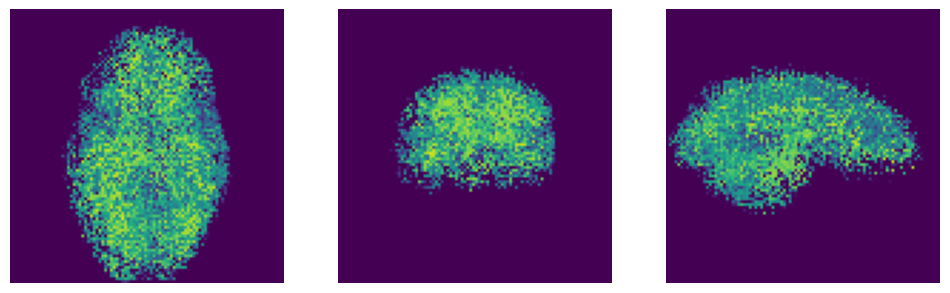

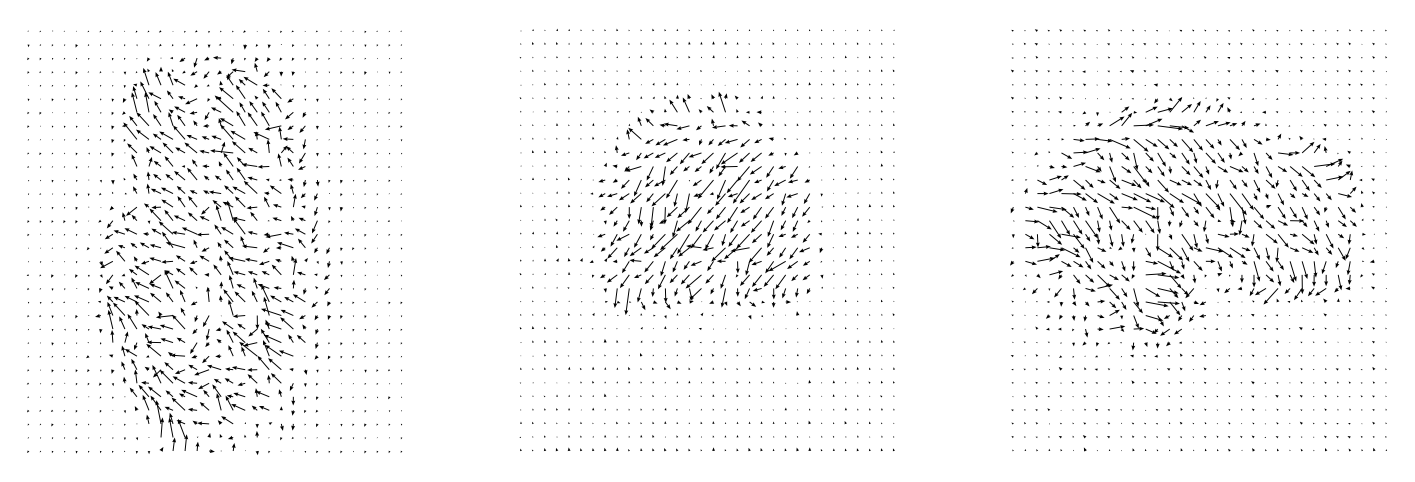

In [91]:
# For warping segmentation labels or class predictions, we sometimes want to use nearest neighbor interpolation
# Note that "bilinear" means "trilinear" in the case of 3D images
warp = monai.networks.blocks.Warp(mode="bilinear", padding_mode="border")
warp_nearest = monai.networks.blocks.Warp(mode="nearest", padding_mode="border")

# Use example reg_net output to apply warp
example_warped_image = warp(
    data_item["img12"][[1], :, :, :].unsqueeze(0), reg_net_example_output  # moving image  # warping
)

# Uncomment to preview warped image from forward pass example above
preview_image(example_warped_image[0,0].detach())

# Uncomment to preview displacement field from forward pass example above
preview_3D_vector_field(reg_net_example_output.detach()[0])

Image similarity loss

In [92]:
lncc_loss = monai.losses.LocalNormalizedCrossCorrelationLoss(
    spatial_dims=3, kernel_size=3, kernel_type="rectangular", reduction="mean"
)

In [93]:
# Uncomment to try out the image similarity loss on the example.

lncc_loss(
    example_warped_image, # registered image
    data_item['img12'][[0],:,:,:].unsqueeze(0) # target ("fixed image")
)

metatensor(-0.0123, grad_fn=<AliasBackward0>)

Regularization loss

In [94]:
bending_loss = monai.losses.BendingEnergyLoss()

# Uncomment to try out the bending energy loss on the example
bending_loss(reg_net_example_output)

metatensor(3.5057, grad_fn=<AliasBackward0>)

# TRAINING

Pretraining segmentation network

In [95]:
# Set up dataloaders

dataloader_seg_available_train = monai.data.DataLoader(
    dataset_seg_available_train, batch_size=4, num_workers=0, shuffle=True #HHHHHHHHHHHHHHHEEEEEEEEEEEERRRRRRRRRRREEEEEEEEE 8
)

dataloader_seg_available_valid = monai.data.DataLoader(
    dataset_seg_available_valid, batch_size=4, num_workers=0, shuffle=False #HHHHHHHHHHHHHHHEEEEEEEEEEEERRRRRRRRRRREEEEEEEEE 16
)

Training

In [98]:
# Training cell
# (if already done then you may skip to and uncomment the checkpoint loading cell below)

seg_net.to(device)

learning_rate = 1e-3
optimizer = torch.optim.Adam(seg_net.parameters(), learning_rate)

max_epochs = 10 # 60
training_losses = []
validation_losses = []
val_interval = 1

for epoch_number in range(max_epochs):
    print(f"Epoch {epoch_number+1}/{max_epochs}:")

    seg_net.train()
    losses = []
    for batch in dataloader_seg_available_train:
        imgs = batch["img"].to(device)
        true_segs = batch["seg"].to(device)
        print(true_segs.shape)
        print(imgs.shape)

        optimizer.zero_grad()
        predicted_segs = seg_net(imgs)
        loss = dice_loss(predicted_segs, true_segs)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    training_loss = np.mean(losses)
    print(f"\ttraining loss: {training_loss}")
    training_losses.append([epoch_number, training_loss])

    if epoch_number % val_interval == 0:
        seg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_seg_available_valid:
                imgs = batch["img"].to(device)
                true_segs = batch["seg"].to(device)
                predicted_segs = seg_net(imgs)
                loss = dice_loss(predicted_segs, true_segs)
                losses.append(loss.item())

        validation_loss = np.mean(losses)
        print(f"\tvalidation loss: {validation_loss}")
        validation_losses.append([epoch_number, validation_loss])

# Free up some memory
del loss, predicted_segs, true_segs, imgs
torch.cuda.empty_cache()

Epoch 1/10:
torch.Size([4, 1, 96, 96, 96])
torch.Size([4, 1, 96, 96, 96])
torch.Size([4, 1, 96, 96, 96])
torch.Size([4, 1, 96, 96, 96])
	training loss: 0.5038380324840546
	validation loss: 0.5057629346847534
Epoch 2/10:
torch.Size([4, 1, 96, 96, 96])
torch.Size([4, 1, 96, 96, 96])
torch.Size([4, 1, 96, 96, 96])
torch.Size([4, 1, 96, 96, 96])
	training loss: 0.4805861860513687
	validation loss: 0.4964878261089325
Epoch 3/10:
torch.Size([4, 1, 96, 96, 96])
torch.Size([4, 1, 96, 96, 96])
torch.Size([4, 1, 96, 96, 96])
torch.Size([4, 1, 96, 96, 96])
	training loss: 0.4584672749042511
	validation loss: 0.48130887746810913
Epoch 4/10:
torch.Size([4, 1, 96, 96, 96])
torch.Size([4, 1, 96, 96, 96])
torch.Size([4, 1, 96, 96, 96])
torch.Size([4, 1, 96, 96, 96])
	training loss: 0.4345531165599823
	validation loss: 0.4587213397026062
Epoch 5/10:
torch.Size([4, 1, 96, 96, 96])
torch.Size([4, 1, 96, 96, 96])
torch.Size([4, 1, 96, 96, 96])
torch.Size([4, 1, 96, 96, 96])
	training loss: 0.4091870486736